<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Загрузка необходимых библиотек:

In [1]:
!pip install -q phik==0.11.1
!pip install -q scikit-learn==1.1.3
!pip install -q shap
!pip install -q lightgbm
!pip install -q feature-engine
!pip install -q pmdarima

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
from lightgbm import LGBMRegressor
import phik
import shap
import pmdarima

In [3]:
# подготовка данных
from sklearn.model_selection import train_test_split
# модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# метрики регрессии
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [248]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import scipy as sp
from scipy import stats
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

In [5]:
# Константы
RANDOM_STATE = 42
RMSE = 48
TEST_SIZE = 0.10

## Подготовка

Чтение исходных данных в таблицы(есть основание считать, что первая колонка может иметь тип времени, попробуем это учесть при чтении таблицы):

In [6]:
try:
    taxi2airport = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi2airport = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

На всякий случай удостоверимся, что данные монотонны по дате

In [7]:
if ~taxi2airport.index.is_monotonic_increasing: taxi2airport.sort_index(inplace=True)

###  Анализ данных 

Начальный размер таблицы:

In [8]:
full_size = taxi2airport.shape[0]
print('Количество оригинальных записей в таблице', full_size)

Количество оригинальных записей в таблице 26496


Выполним предобработку данных, предварительно оценив что должно содержаться в таблице

In [9]:
taxi2airport.sample(7).T

datetime,2018-06-27 20:00:00,2018-08-29 13:00:00,2018-07-01 14:50:00,2018-04-09 17:40:00,2018-06-22 23:30:00,2018-06-25 12:30:00,2018-06-05 09:10:00
num_orders,20,18,19,6,19,6,20


Выведем информацию о столбцах:

In [10]:
taxi2airport.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет 

In [11]:
print ('Начало периода наблюдений',taxi2airport.index[0])
print ('Окончание периода наблюдений',taxi2airport.index[-1])

Начало периода наблюдений 2018-03-01 00:00:00
Окончание периода наблюдений 2018-08-31 23:50:00


Данные представлены за 6 месяцев, начиная с марта 2018 года

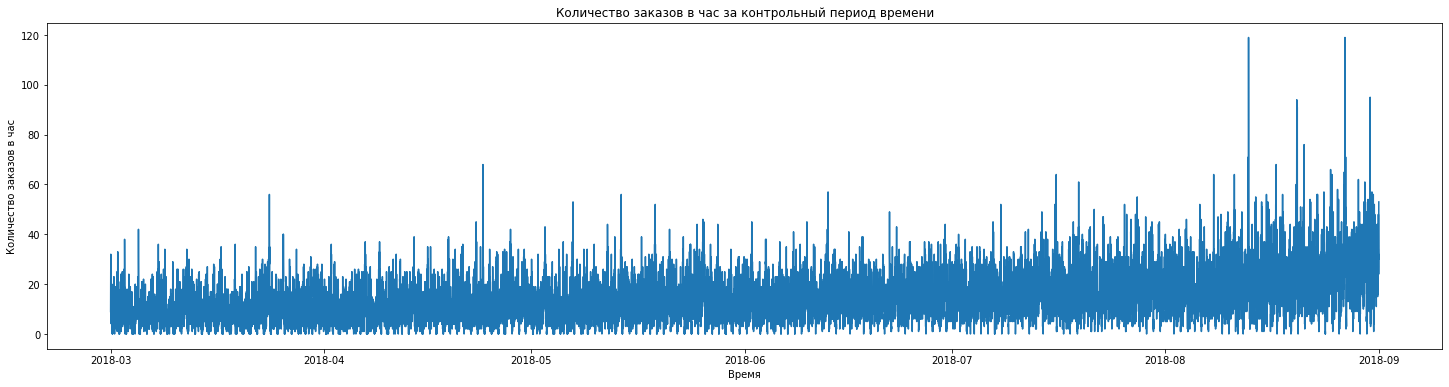

In [12]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(taxi2airport)
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов в час')
plt.title ('Количество заказов в час за контрольный период времени')
plt.show()

Посмотрим общие предельные значения:

In [13]:
taxi2airport.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


В среднем у час около 14 заказов, присутствуют часы простоя с 0 заказов.

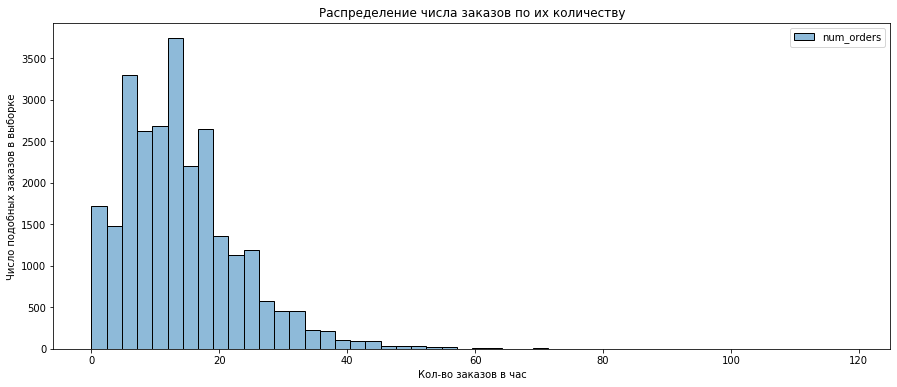

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=taxi2airport, bins=50, color='tab:orange')
ax.set_xlabel('Кол-во заказов в час')
ax.set_ylabel('Число подобных заказов в выборке')
plt.title ('Распределение числа заказов по их количеству')
plt.show()

###  Ресемплирование

Выполним  ресемплирование по одному часу

In [15]:
taxi2airport = taxi2airport.resample('1H').sum()

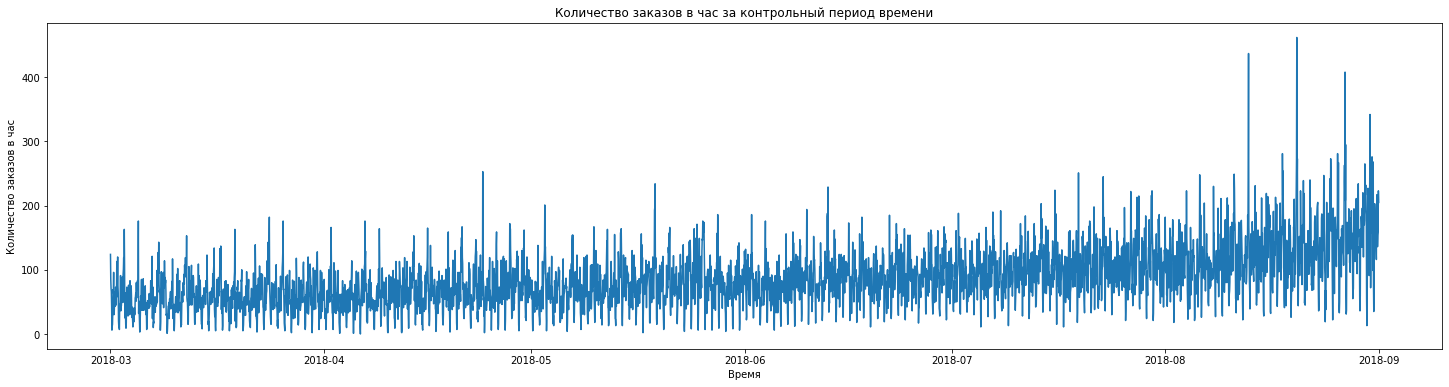

In [16]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(taxi2airport)
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов в час')
plt.title ('Количество заказов в час за контрольный период времени')
plt.show()

## Анализ

### Тренды и сезонность

Оценим наличие тренда и сезонности. Это пригодится при построении моделей и формировании набора признаков

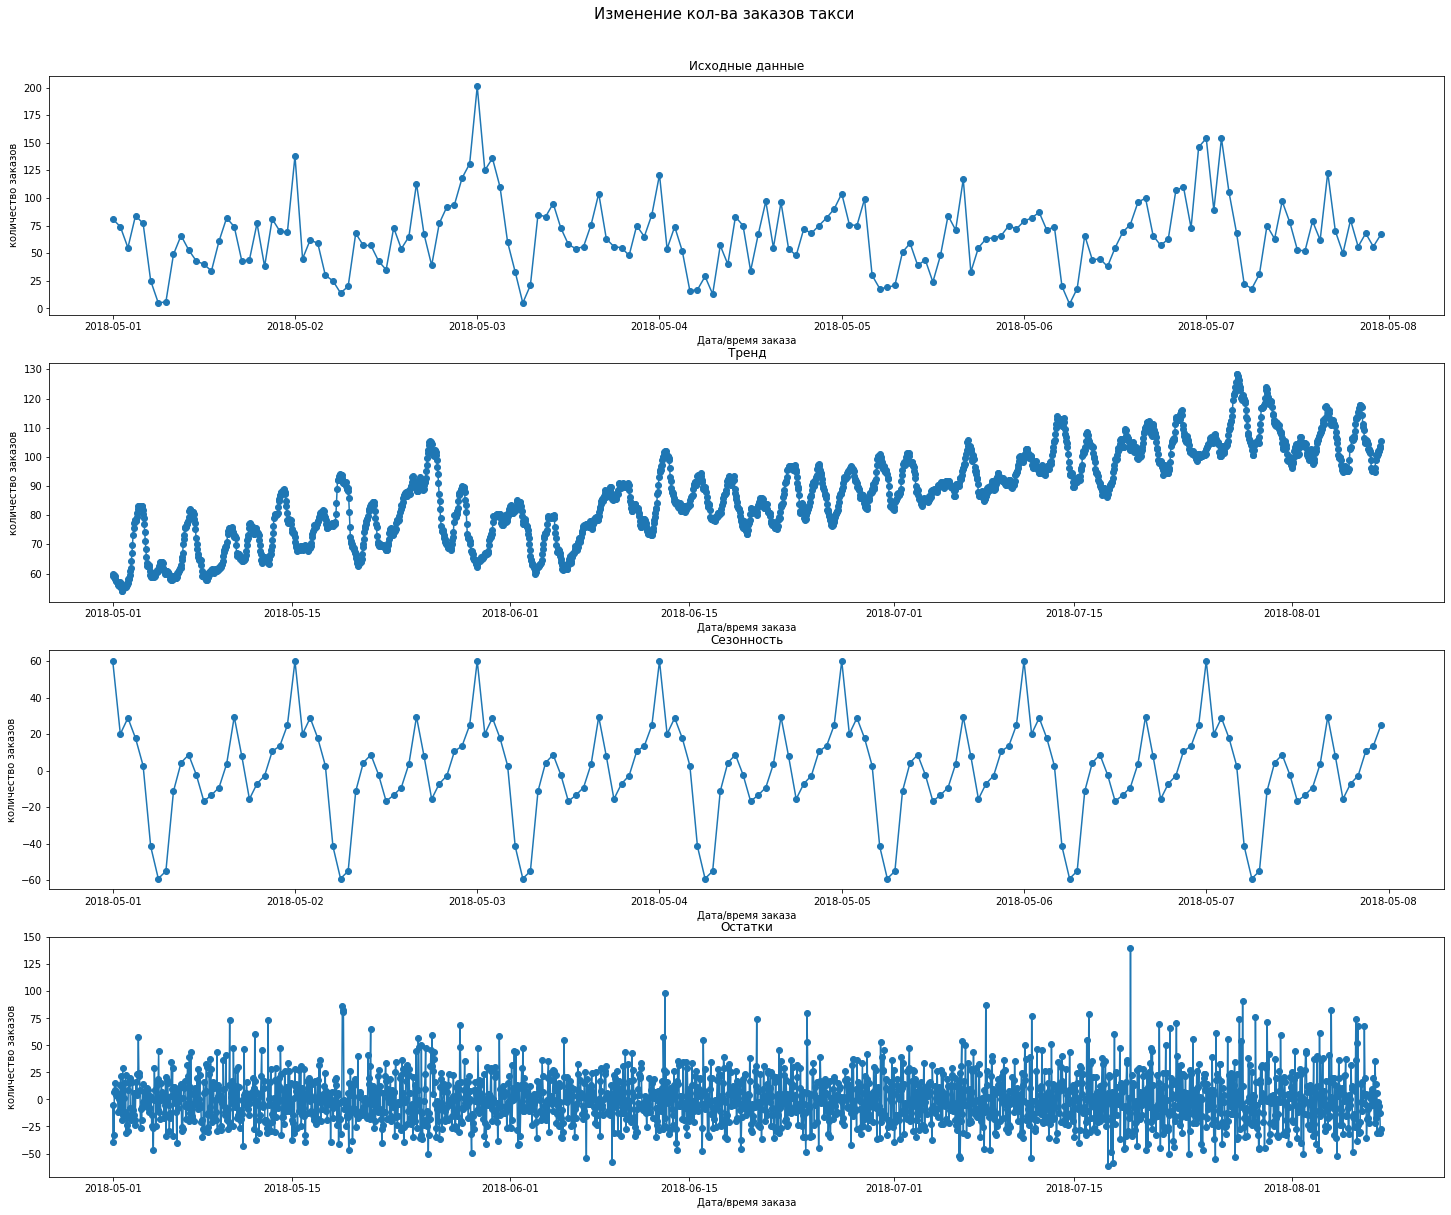

In [17]:
result = seasonal_decompose(taxi2airport, model='additive')
fig, ax = plt.subplots(4, figsize=(25, 19))
fig.suptitle('Изменение кол-ва заказов такси', fontsize=15)
fig.subplots_adjust(top = 0.93)
ax[0].plot(taxi2airport['2018-05-01':'2018-05-07'], marker='o')
ax[0].set_title('Исходные данные')
ax[1].plot(result.trend['2018-05-01':'2018-08-07'], marker='o')
ax[1].set_title('Тренд')
ax[2].plot(result.seasonal['2018-05-01':'2018-05-07'], marker='o')
ax[2].set_title('Сезонность')
ax[3].plot(result.resid['2018-05-01':'2018-08-07'], marker='o')
ax[3].set_title('Остатки')
for i, axis in enumerate(ax):
    ax[i].set_ylabel('количество заказов')
    ax[i].set_xlabel('Дата/время заказа')
plt.show()

Чтобы оценить насколько удалось использовать информацию содержащуюся в ряду, оценим распределение остатков на нормальность. Оценку нормальности распределения можно провести на основе теста Шапиро либо с использованием графического отображения в ввиде p-p диаграммах (график квантиль-квантиль). Тест Шапиро отображает вероятность случайного отклонения от нормального распределения, для случая p- value < 5% эта гипотеза отвергается. 

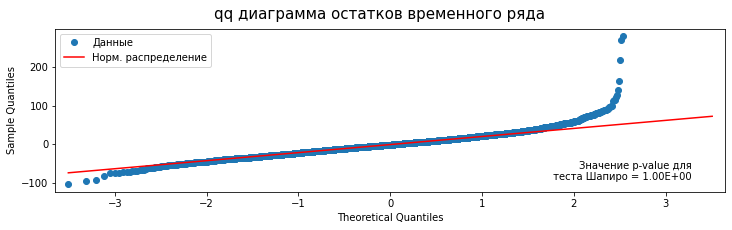

In [18]:
fig, ax = plt.subplots(figsize=(12, 3))
fig.suptitle('qq диаграмма остатков временного ряда', fontsize=15)
plt.subplots_adjust(wspace=0.5) 
tst=sp.stats.shapiro(result.resid)
sm.qqplot(result.resid, line='q', ax=ax)
ax.legend(['Данные', 'Норм. распределение'],
      loc="upper left",
      bbox_to_anchor=(0.0, 0, 0.1, 1))
ax.text(0.95, 0.07, f'Значение p-value для\n теста Шапиро = {tst.pvalue:.2E}' , transform=ax.transAxes, horizontalalignment='right')
plt.show()

Никакой дополнительной информации в остатках не осталось.

Можно отметить следующие наблюдения:
 - присутствует тренд к росту числа заказов;
 - сезонность заказов составляет 24 часа (1 день);
 - остатки распределены нормально, а следовательно не содержат дополнительной информации о ряде.


### Стационарность ряда

Перед тем, как перейти к моделированию, стоит оценить стационарность временного ряда

Используем тест Dickey-Fuller:
 - Нулевая гипотеза (H0): Означает, что временной ряд имеет единичный корень, то есть он нестационарен (p-value > 0.05);
 - Альтернативная гипотеза (H1): Временной ряд не имеет единичного корня, то есть он стационарен (p-value <= 0.05).

In [19]:
X = taxi2airport.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


На всякий случай отметим, что стационарные ряды лучше для прогнозирования ............если бы ряд был нестационарным свести его к стационарному можно было бы :

 - трансформацией типа Бокса-Кокса (для дисперсии);
 - дифференцирование для стабилизации трендов и сезонности.

Хотя наш ряд стационарный, но наличие тренда может помешать в его анализе, уберем его выполнив дифференцирование ряда с шагом в 1 час.

In [20]:
dSeriasdt = (taxi2airport-taxi2airport.shift(1)).dropna()
dSeriasdt = dSeriasdt.dropna() 
X = dSeriasdt.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.793234
p-value: 0.000000
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Далее для анализа можно избавиться от сезонности. Для этого возмем сезонную разность, от нашего получившегося ряда. Здесь следует отметить, что далее попробуем использовать несколько эконометрических моделей SARIMAX(с учетом сезонности) и AutoReg.

In [21]:
dSeriasdtdt = (dSeriasdt-dSeriasdt.shift(24)).dropna() 
X = dSeriasdtdt.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.208020
p-value: 0.000000
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Диаграммы автокорреляций ACF и PACF, генерация признаков (Скользящее среднее и Отстающие значения)

Для понимания сезонности и лага, построим графики ACF / PCF для исходного ряда, ряда разностей по одному часу и ряда разности второго порядка по периоду сезонности

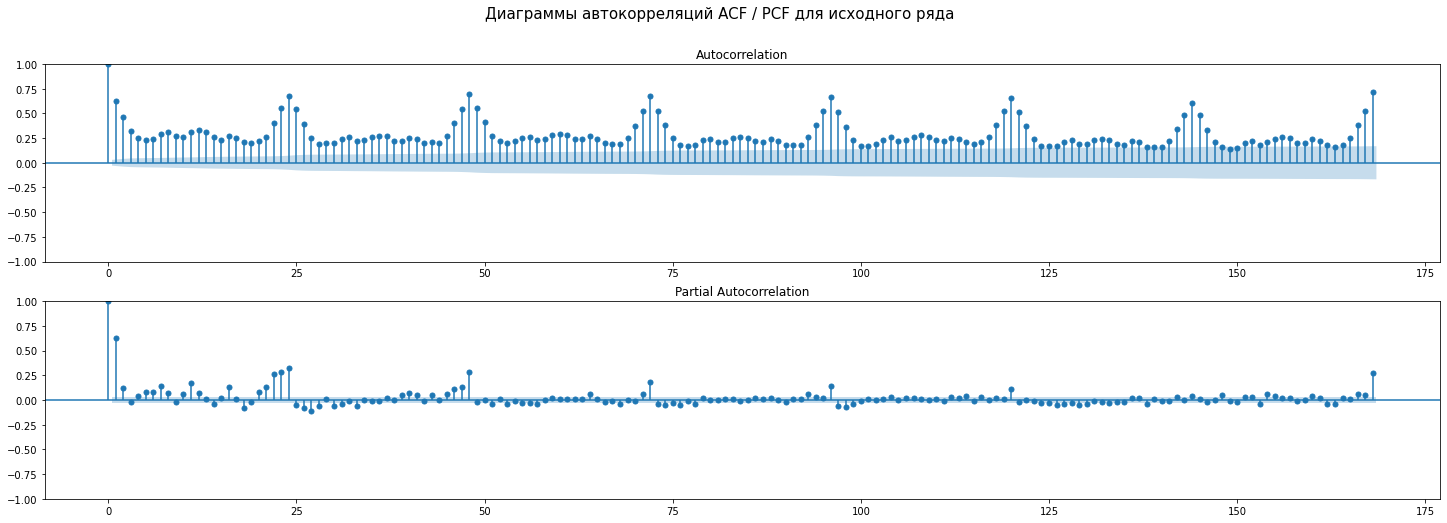

In [22]:
fig, ax = plt.subplots(2, figsize=(25, 8))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для исходного ряда', fontsize=15)
plot_acf(taxi2airport, ax= ax[0],  lags = 24*7)
plot_pacf(taxi2airport,  ax= ax[1], lags = 24*7)
plt.show()

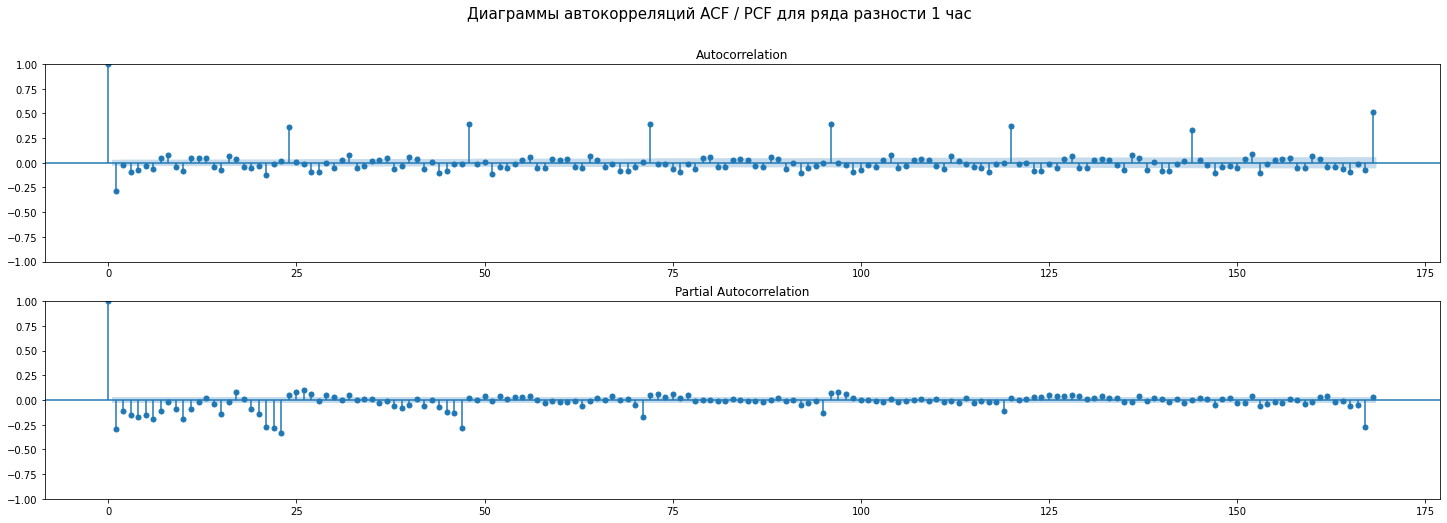

In [23]:
fig, ax = plt.subplots(2, figsize=(25, 8))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для ряда разности 1 час', fontsize=15)
plot_acf(dSeriasdt, ax= ax[0],  lags = 24*7)
plot_pacf(dSeriasdt,  ax= ax[1], lags = 24*7)
plt.show()

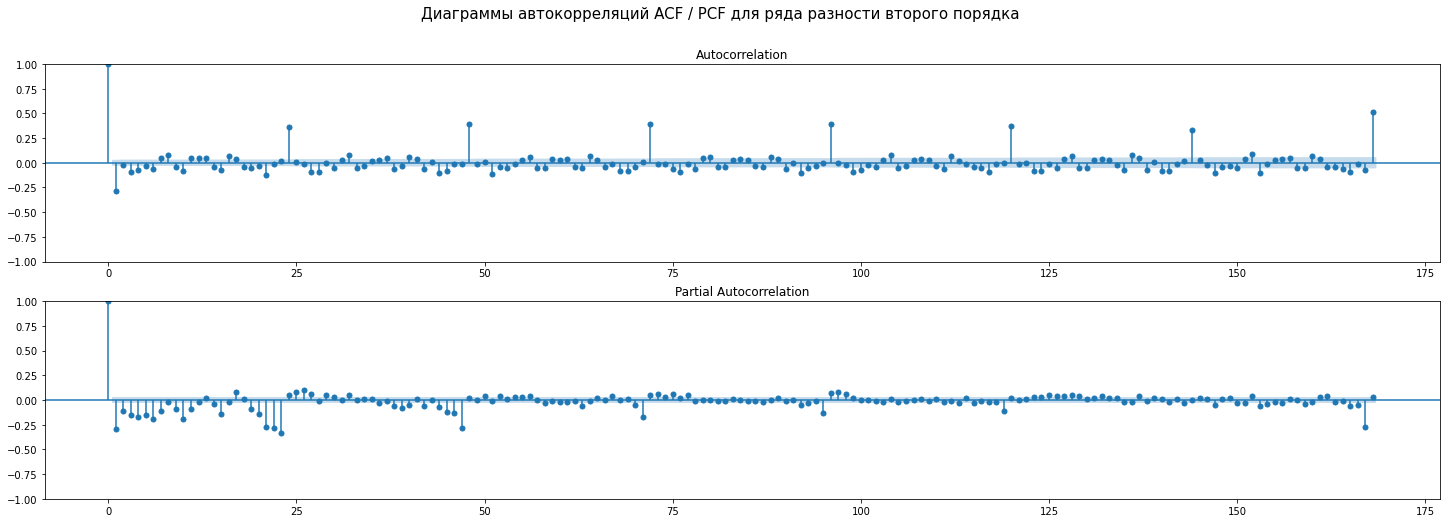

In [24]:
fig, ax = plt.subplots(2, figsize=(25, 8))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для ряда разности второго порядка', fontsize=15)
plot_acf(dSeriasdt, ax= ax[0],  lags = 24*7)
plot_pacf(dSeriasdt,  ax= ax[1], lags = 24*7)
plt.show()

Два последних ряда используем в эконометрическом подход (модели AutoReg, ARIMA и SARIMAX)

Диаграммы PCF позволяет оценить AR, тогда используем принятое обозначение и выделим следующие лаги:

In [25]:
ps = [1, 2, 3,  4,  8, 9,  12, 13, 21, 22, 23, 24*1, 24*2, 24*3 , 24*4, 24*5, 24*7, 27]   # для всех моделей далее
PS = [1, 6, 10, 21, 22, 23,  24*2, 24*7]  # для модели SARIMAX

Диаграммы ACF позволяет оценить MA, тогда используем принятое обозначение и выделим следующие скользящие средние (фактически сезонность):

In [26]:
qs = [24]  # для всех моделей далее
QS = [24]  # для модели SARIMAX

Так как будет обучать и модели регрессии посмотрим матрицу корреляций phik для лагов и скользящего среднего:

In [27]:
lag_test = taxi2airport.copy()
lag_test['MA'] = taxi2airport['num_orders'].shift().rolling(24).mean()
for lag in ps:
    lag_test['AR_{}'.format(lag)] = lag_test['num_orders'].shift(lag)

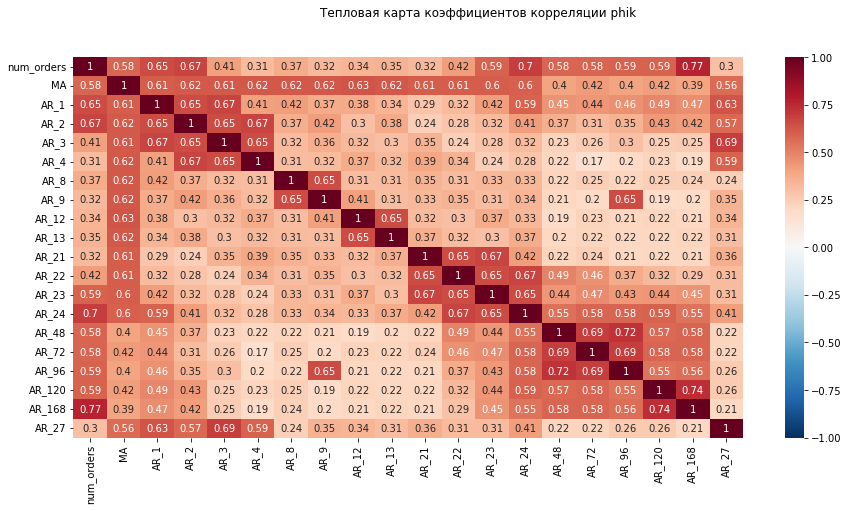

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = lag_test.phik_matrix(interval_cols= lag_test.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Видна устойчивая корреляционная связь с исходными значениями. Можно отметить, что если бы тут был бы ряд разностей она бы ослаблялась с ростом лага из-за отсутствия тренда.

In [29]:
feat_acf = lag_test.drop(columns = ['num_orders'])
feat_acf.sample(5)

,MA,AR_1,AR_2,AR_3,AR_4,AR_8,AR_9,AR_12,AR_13,AR_21,AR_22,AR_23,AR_24,AR_48,AR_72,AR_96,AR_120,AR_168,AR_27
datetime,,,,,,,,,,,,,,,,,,,
2018-07-21 16:00:00,108.833333,117.0,86.0,72.0,78.0,90.0,44.0,96.0,171.0,64.0,108.0,143.0,121.0,125.0,146.0,57.0,124.0,168.0,105.0
2018-08-24 21:00:00,135.541667,179.0,113.0,137.0,170.0,144.0,118.0,170.0,95.0,247.0,170.0,130.0,182.0,137.0,160.0,153.0,93.0,144.0,160.0
2018-03-12 15:00:00,77.208333,58.0,64.0,45.0,84.0,19.0,15.0,51.0,57.0,107.0,78.0,93.0,60.0,93.0,44.0,78.0,51.0,45.0,50.0
2018-05-31 20:00:00,77.750000,62.0,36.0,80.0,101.0,65.0,88.0,71.0,17.0,85.0,79.0,115.0,98.0,54.0,67.0,78.0,85.0,143.0,88.0
2018-07-30 11:00:00,121.666667,131.0,120.0,86.0,32.0,155.0,223.0,177.0,135.0,135.0,116.0,108.0,60.0,104.0,110.0,86.0,93.0,136.0,62.0


### Генерация календарных признаков

Под календарными признаками понимаем все данные, которые можно извлечь из дат временного ряда:

 - месяц;
 - неделя;
 - день недели;
 - день;
 - время суток(разделим на ночь, утро, день и вечер);
 - час.

In [30]:
feat_kalend = taxi2airport.copy()
feat_kalend['Day'] = taxi2airport.index.day
feat_kalend['Hour'] = taxi2airport.index.hour
feat_kalend['Week'] = taxi2airport.index.week
feat_kalend['DayofWeek'] = taxi2airport.index.dayofweek
feat_kalend['Month'] = taxi2airport.index.month
feat_kalend['TimeofDay'] = ((feat_kalend['Hour']+6)//6)
feat_kalend.head(5)

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


,num_orders,Day,Hour,Week,DayofWeek,Month,TimeofDay
datetime,,,,,,,
2018-03-01 00:00:00,124,1,0,9,3,3,1
2018-03-01 01:00:00,85,1,1,9,3,3,1
2018-03-01 02:00:00,71,1,2,9,3,3,1
2018-03-01 03:00:00,66,1,3,9,3,3,1
2018-03-01 04:00:00,43,1,4,9,3,3,1


Так как будет обучать и модели регрессии посмотрим матрицу корреляций phik для календарных признаков:

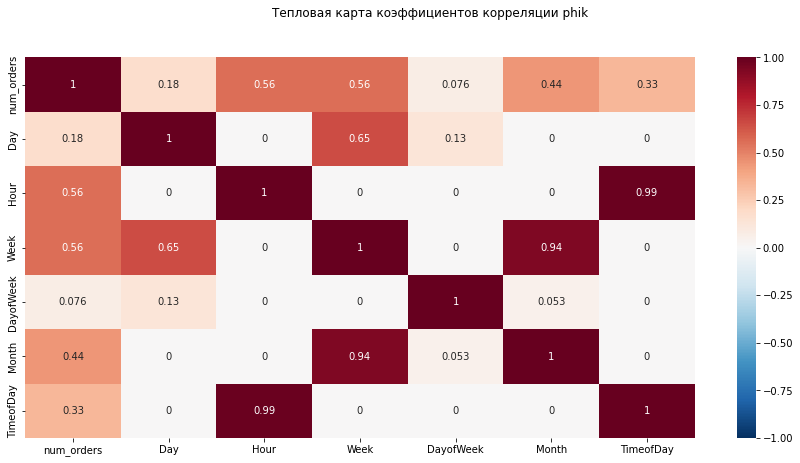

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = feat_kalend.phik_matrix(interval_cols= feat_kalend.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Присутствует мультиколлинеарность в признаках:

 - TimeofDay - Hour (уберем TimeofDay);
 - Week - Month (уберем Month, неделя года будет отвечать за тренд);
 - 
День недели похоже что не сильно коррелирует с числом заказов (что странно, все таки оставим его пока)

In [32]:
feat_kalend = feat_kalend.drop(columns = ['Month', 'TimeofDay'])
feat_kalend.sample(5)

,num_orders,Day,Hour,Week,DayofWeek
datetime,,,,,
2018-06-14 14:00:00,55,14,14,24,3
2018-04-08 10:00:00,39,8,10,14,6
2018-07-13 19:00:00,140,13,19,28,4
2018-06-06 18:00:00,50,6,18,23,2
2018-04-08 15:00:00,71,8,15,14,6


Новые временные признаки Day, Hour и DayofWeek цикличны, что может сбить с толку регрессионные модели. Закодируем их отдельно с использование sin/cos преобразования.

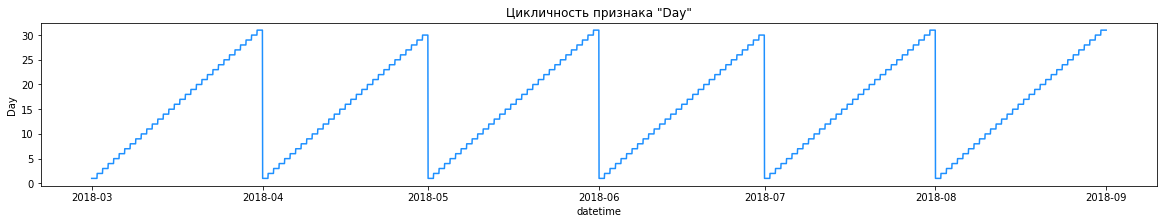

In [217]:
f, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(x=feat_kalend.index, y=feat_kalend['Day'], color='dodgerblue')
ax.set_title('Цикличность признака "Day"')
plt.show()

In [219]:
days_in_month = 30
feat_kalend['Day_sin'] = np.sin(2*np.pi*feat_kalend['Day']/days_in_month)
feat_kalend['Day_cos'] = np.cos(2*np.pi*feat_kalend['Day']/days_in_month)
hours_in_day = 24
feat_kalend['Hour_sin'] = np.sin(2*np.pi*feat_kalend['Hour']/hours_in_day)
feat_kalend['Hour_cos'] = np.cos(2*np.pi*feat_kalend['Hour']/hours_in_day)
days_in_week = 24
feat_kalend['DayofWeek_sin'] = np.sin(2*np.pi*feat_kalend['DayofWeek']/days_in_week)
feat_kalend['DayofWeek_cos'] = np.cos(2*np.pi*feat_kalend['DayofWeek']/days_in_week)

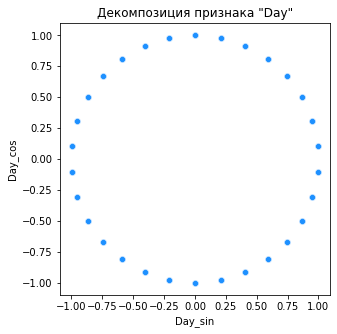

In [224]:
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=feat_kalend['Day_sin'], y=feat_kalend['Day_cos'], color='dodgerblue')
ax.set_title('Декомпозиция признака "Day"')
ax.set_aspect('equal', 'box')
plt.show()

In [227]:
feat_kalend = feat_kalend.drop(columns = ['Day', 'Hour', 'DayofWeek'])

Объединим признаки у одну таблицу:

In [228]:
frame2model = pd.concat([feat_kalend, feat_acf], axis=1)
frame2model.head(5)

,num_orders,Week,Day_sin,Day_cos,Hour_sin,Hour_cos,DayofWeek_sin,DayofWeek_cos,MA,AR_1,...,AR_21,AR_22,AR_23,AR_24,AR_48,AR_72,AR_96,AR_120,AR_168,AR_27
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,9,0.207912,0.978148,0.000000,1.000000,0.707107,0.707107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,9,0.207912,0.978148,0.258819,0.965926,0.707107,0.707107,NaN,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,9,0.207912,0.978148,0.500000,0.866025,0.707107,0.707107,NaN,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,9,0.207912,0.978148,0.707107,0.707107,0.707107,0.707107,NaN,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,9,0.207912,0.978148,0.866025,0.500000,0.707107,0.707107,NaN,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим на мультиколлинеарность

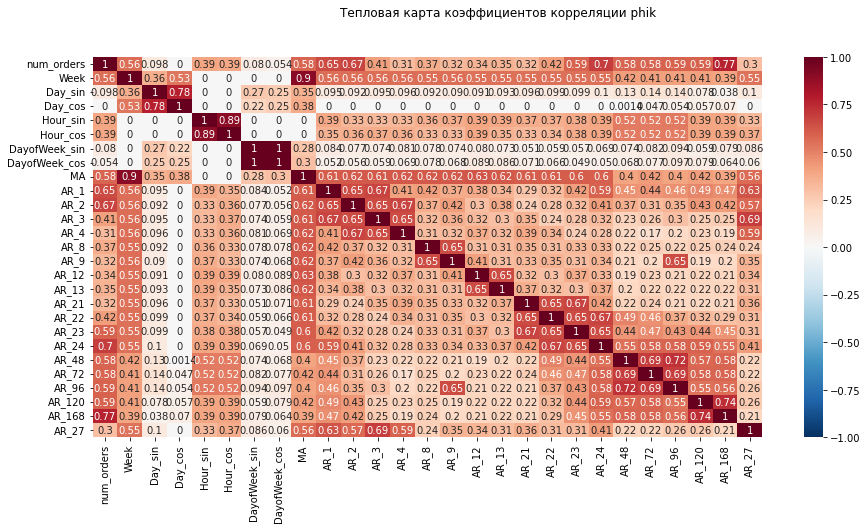

In [229]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = frame2model.phik_matrix(interval_cols= frame2model.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Неделя сильно коррелирует с MA, уберем неделю.

In [231]:
frame2model = frame2model.drop(columns = ['Week'])

Можно переходить к этапу моделирование.

## Обучение

### Эконометрический подход. Метод ARIMA и AutoReg

In [181]:
metrics = []

Разобьем исходный ряд(используем исходный ряд) на тестовые и тренеровочные данные:

In [338]:
train, test = train_test_split(taxi2airport, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
train_len = len(train)
num_samples = len(taxi2airport)

**Модель AutoReg**

In [182]:
auto_reg_model = AutoReg(train, lags=ps ).fit()
pred_train = auto_reg_model.predict(start=max(ps), end=train_len-1, dynamic=False)
print('Точность модели на тестовой выборке: RMSE = ', mean_squared_error(train[max(ps):train_len], pred_train, squared=False))
metrics.append(['AutoReg', round(mean_squared_error(train[max(ps):train_len], pred_train, squared=False),2)])

Точность модели на тестовой выборке: RMSE =  21.22577009415675


**Модель ARIMA**

Для модели ARIMA без учета сезонности подберем параметры на тренеровочных данных в пределах:

 - ps [1:12];
 - qs [1:24|]. 

In [185]:
auto_arima(train, test='adf', trace=True, error_action='ignore', suppress_warnings=True, start_p = 1, max_p=12, max_q = 24, d=1, stepwise=True, maxiter = 20)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39785.522, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39407.923, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39248.315, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39783.522, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39246.314, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39405.923, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.796 seconds


ARIMA(maxiter=20, order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Применим полученнуую модель для прогнозирования тестовых данных.

In [192]:
%%time
arima_model = ARIMA(train, order=(0,1,1)).fit()
pred_train = arima_model.predict(start=max(ps), end=train_len-1, dynamic=False)
print('Точность модели на тестовой выборке: RMSE = ', mean_squared_error(train[max(ps):train_len], pred_train, squared=False))
metrics.append(['ARIMA', round(mean_squared_error(train[max(ps):train_len], pred_train, squared=False),2)])

Точность модели на тестовой выборке: RMSE =  34.01709986782892
CPU times: total: 250 ms
Wall time: 263 ms


**Модель SARIMA**

В отличии от предыдущей модели может учитыват сезонность, которая у нас 24 часа. Подберем параметры в том же диапазоне. Для сокращения времени расчета отметим, что PS = 1, D=1 и QS=0 (я что то пробовал, но получается долго очень и прям не видно на горизонте улучшения качества)

In [189]:
auto_arima(train, test='adf', trace=True, error_action='ignore', suppress_warnings=True, max_p=12,
           max_q=24, d=1, start_P=1, max_P=1, start_Q=0, max_Q=0, stepwise=True, maxiter = 15, seasonal=True, m=24)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=11.14 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=39785.522, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=38311.575, Time=3.80 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=39248.315, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=39783.522, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=39407.923, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=39060.987, Time=3.55 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=38073.828, Time=6.09 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=39343.303, Time=0.27 sec
 ARIMA(3,1,0)(1,0,0)[24] intercept   : AIC=37955.658, Time=11.31 sec
 ARIMA(3,1,0)(0,0,0)[24] intercept   : AIC=39265.894, Time=0.54 sec
 ARIMA(4,1,0)(1,0,0)[24] intercept   : AIC=37880.917, Time=15.29 sec
 ARIMA(4,1,0)(0,0,0)[24] intercept   : AIC=39163.463, Time=0.52 sec
 ARIMA(5,1,0)(1,0,0)[24] intercept   : AIC=37832.435, Time=16.72 sec
 ARIMA(

ARIMA(maxiter=15, order=(12, 1, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 24), suppress_warnings=True,
      with_intercept=False)

In [190]:
%%time
sarimax_model = SARIMAX(train, order=(12, 1, 0), seasonal_order=(1, 0, 0, 24)).fit()
pred_train = sarimax_model.predict(start=max(ps), end=train_len-1, dynamic=False)
print('Точность модели на тестовой выборке: RMSE = ', mean_squared_error(train[max(ps):train_len], pred_train, squared=False))
metrics.append(['SARIMAX', round(mean_squared_error(train[max(ps):train_len], pred_train, squared=False),2)])

Точность модели на тестовой выборке: RMSE =  27.318808311519838
CPU times: total: 15.8 s
Wall time: 16.3 s


In [199]:
metrics = pd.DataFrame(metrics)
metrics.columns = ['Model ', 'Train_metric']
metrics

,Model,Train_metric
0,AutoReg,21.23
1,ARIMA,72.84
2,ARIMA,62.77
3,AutoReg,34.02
4,SARIMAX,27.32
5,ARIMA,34.02


Лучшую метрику из эконометрических моделей показала модель AutoReg. Она самая простая и быстрообучаемая. Получим значения на тестовой выборке.

In [339]:
pred_ec = auto_reg_model.predict(start=train_len, end=num_samples-1)
print('Точность модели на тестовой выборке: RMSE = ', mean_squared_error(test['num_orders'], pred_ec, squared=False))

Точность модели на тестовой выборке: RMSE =  39.115447001670525


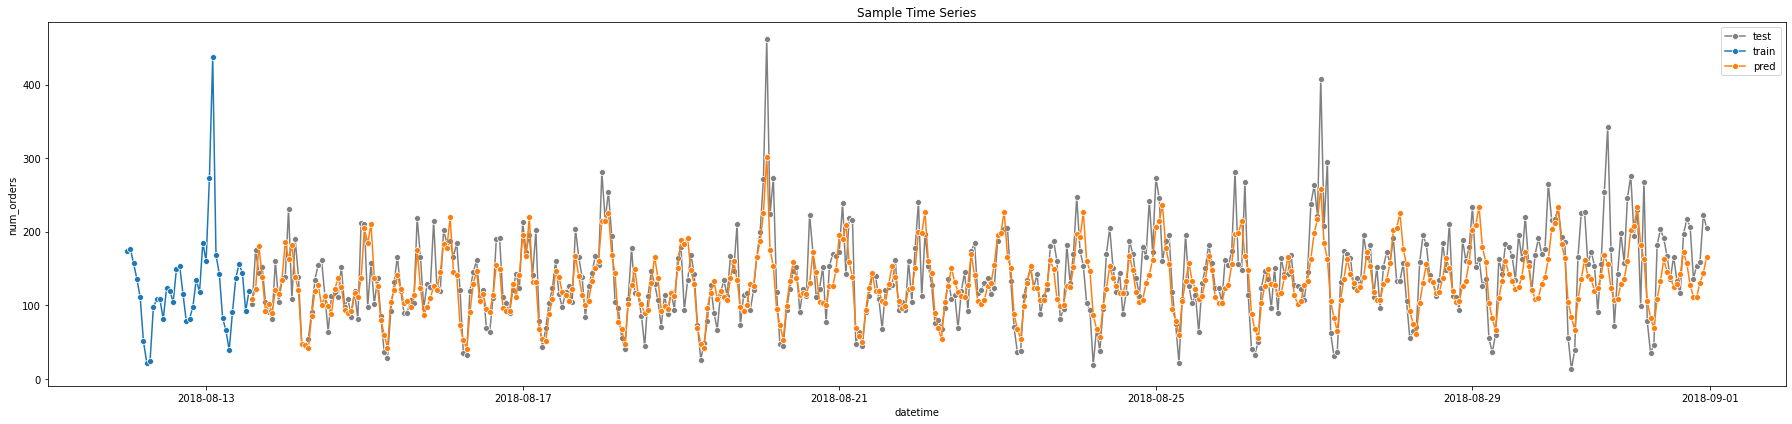

In [340]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
sns.lineplot(taxi2airport[test.index[0]:test.index.max()]['num_orders'], marker='o', label='test', color='grey')
sns.lineplot(taxi2airport['2018-08-12':train.index.max()]['num_orders'], marker='o', label='train')
sns.lineplot(x=taxi2airport.index[train_len:num_samples], y=pred_ec.values, marker='o', label='pred')
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

Качество модели соответствует заявленному критерием 48.

Ради интереса выведем на экран значения временного ряда предсказанные моделью SARIMA

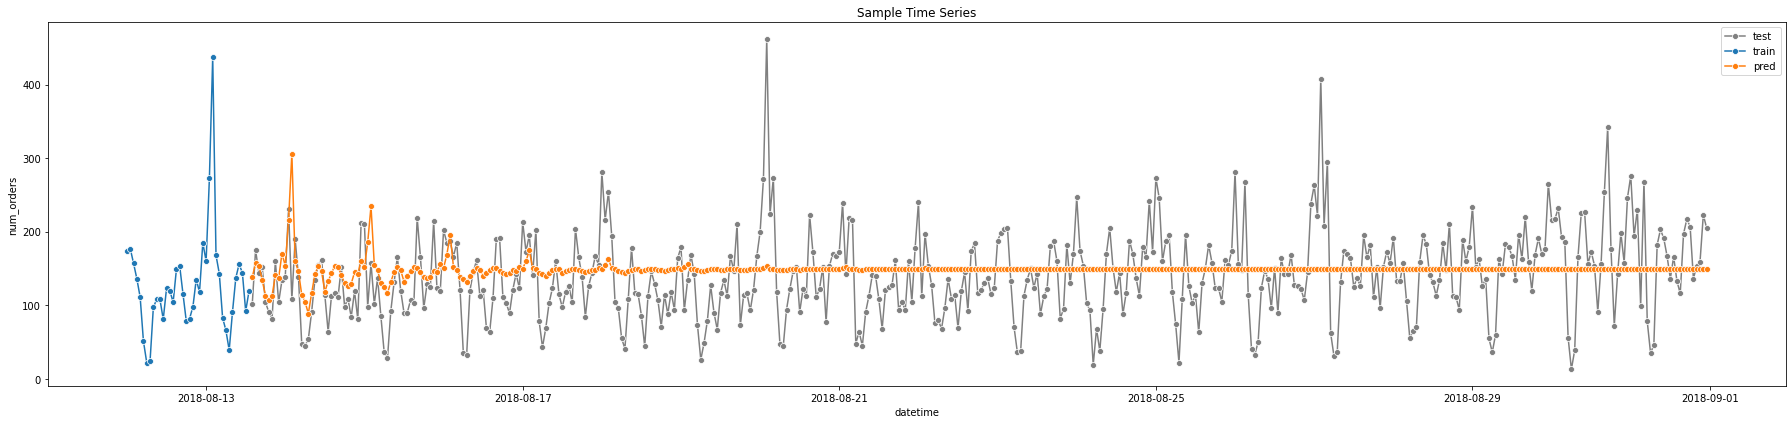

In [202]:
pred = sarimax_model.predict(start=train_len, end=num_samples-1)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
sns.lineplot(taxi2airport[test.index[0]:test.index.max()]['num_orders'], marker='o', label='test', color='grey')
sns.lineplot(taxi2airport['2018-08-12':train.index.max()]['num_orders'], marker='o', label='train')
sns.lineplot(x=taxi2airport.index[train_len:num_samples], y=pred.values, marker='o', label='pred')
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

Значения очень быстро "скатились" до среднего. Почему так, я в итоге не понял, мне кажется потому что сезонность очень маленькая по сравнению с горизонтом прогнозирования, либо параметры должны быть более высокого порядка(но тут производительности компьютера не хватило)

### Регрессионныые модели машинного обучения

Разобьем сформированные данные на тестовые и тренеровочные

In [341]:
frame2model= frame2model.dropna()
train, test = train_test_split(frame2model, shuffle=False, test_size=TEST_SIZE)

Выделим в сформированной таблице, целевой признак и все остальные (которые числовые):

In [239]:
target = ['num_orders']
num_col = frame2model.select_dtypes(include=np.number).columns.values
num_col = num_col[~np.isin(num_col, target)]
argument_col = num_col

Создадим функцию для формирования PipeLine:

In [243]:
def prediction_model(X_num, NumScaler, model_step, types = None):
    # выбор масшабирования
    if NumScaler == 'Standart':
        Scaler = StandardScaler()
    elif NumScaler == 'Robust': 
        Scaler = RobustScaler()    
    elif NumScaler == 'Quantile': 
        Scaler = QuantileTransformer()
    else:
        Scaler = MinMaxScaler()
    num_features = X_num.tolist()
    # преобразование численных признаков
    num_steps = [('Scaler', Scaler)]
    # создаём пайплайы обработки
    num_transformer = Pipeline(num_steps)
    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_features)],        
        remainder='passthrough')
    # создаём итоговый пайплайн по шагам
    step_prep = ('preprocessor', data_preprocessor)
    # выбор модели 
    if model_step == 'Dummy':
        step_sol  = ('model', DummyRegressor(strategy="mean"))
    elif model_step == 'init':
        step_sol  = ('model', LinearRegression(n_jobs=-1))
    elif model_step == 'user':
        step_sol  = ('model', types)     
    # собираем шаги модели
    return Pipeline([step_prep, step_sol])

Проверим работоспоспособность на модели линейной регрессии:

In [252]:
lin_model = prediction_model(num_col, 'Min/Max', 'init')
lin_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Day_sin', 'Day_cos',
                                                   'Hour_sin', 'Hour_cos',
                                                   'DayofWeek_sin',
                                                   'DayofWeek_cos', 'MA',
                                                   'AR_1', 'AR_2', 'AR_3',
                                                   'AR_4', 'AR_8', 'AR_9',
                                                   'AR_12', 'AR_13', 'AR_21',
                                                   'AR_22', 'AR_23', 'AR_24',
                                                   'AR_48', 'AR_72', 'AR_96',
                                                   'AR_120', 'AR_168',
                                                   'AR_27'])])),
                ('model', LinearRegression(n_jobs=-1))])

Для кросс-валидации нужен специальный метод, так как "мешать" фолды нельзя, используем TimeSeriesSplit

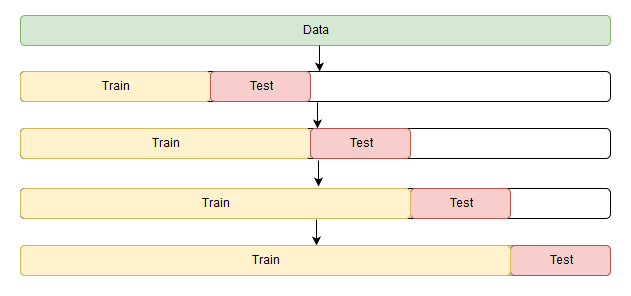

In [249]:
tcv = TimeSeriesSplit(n_splits=5)

In [253]:
%%time
rmse_accure_cv = cross_val_score(
    lin_model,
    train[num_col],
    train[target],
    scoring='neg_mean_squared_error',
    cv=tcv,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: RMSE = ', np.sqrt(abs(rmse_accure_cv)))

Точность модели на тренировочной выборке: RMSE =  22.242182307065466
CPU times: total: 109 ms
Wall time: 3.24 s


Линейная модель показывает результат на тренировочных данных значительно лучше, чем необходимо, однако продолжим исследовать модели.

**Анализ моделей**

Исследуем следующие модели:
- Для **Ridge()** исследуем гиперпараметр alpha (l2 регуляризация);
- Для **Lasso()** исследуем гиперпараметр alpha (l1 регуляризация);
- Для **RandomForestRegressor()** max_depth ;
- Для **CatBoostRegressor()**  learning_rate;
- Для **LightGBM()**  learning_rate.

In [294]:
def param_grid_choose(type_of_model, min_samples_split, min_samples_leaf, alpha, learning_rate, n_estimators, max_depth):
# типы моделей DecisionTreeClassifier/KNeighborsClassifier/SVC/CatBoostClassifier/LogisticRegression
    if type_of_model == 'LightGBM':
        # словарь для модели LightGBM
        param_grid = [{
        'model': [LGBMRegressor(verbose=-1)],
        'model__num_leaves': num_leaves,
        'model__max_depth': max_depth,
        'model__max_bin': max_bin
                   }]    
    elif type_of_model == 'Ridge':
        # словарь для модели KNeighborsClassifier 
         param_grid = [{
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': alpha
  #        , 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
                      }]  
    elif type_of_model == 'Lasso':
        # словарь для модели Lasso
        param_grid = [{
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': alpha  
                    }]
    elif type_of_model == 'CatBoostRegressor':
        # словарь для модели CatBoostClassifier   
        param_grid = [{
        'model': [CatBoostRegressor(iterations=1000, random_state=RANDOM_STATE, loss_function='RMSE', logging_level ='Silent')],
        'model__learning_rate': learning_rate
                    }]
    elif type_of_model == 'RandomForestRegressor':
        # словарь для модели RandomForestRegressor   
        param_grid = [{
        'model': [RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)],
        'model__n_estimators': n_estimators, 
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf  
                    }]
    return param_grid

In [302]:
# Ridge&Lasso parameters
alpha               = [0.1, 0.5, 1, 5, 25, 50, 100]        
# CatBoostRegressor & LightGBM parameters
learning_rate       = [0.1, 0.25, 0.5, 0.75]
num_leaves          = [31, 33, 35, 37]
max_bin             = [200, 255, 300]
# RandomForestRegressor parameters
n_estimators        = [10, 100] # default 100     
max_depth           = [None, 3, 5, 7] # default None 
min_samples_split   = [2, 10, 20, 30, 35] 
min_samples_leaf    = [2, 10, 20, 30, 35] 

In [303]:
model_list = ['LightGBM' , 'Ridge', 'Lasso', 'CatBoostRegressor', 'RandomForestRegressor']
model_list = ['LightGBM']
metrics_reg = []
for i, model in enumerate(model_list):
    time2start = time()
    params   = param_grid_choose(model, min_samples_split, min_samples_leaf, alpha, learning_rate, n_estimators, max_depth)
    searcher = RandomizedSearchCV(lin_model, 
                              param_distributions = params, 
                              cv=tcv,
                              scoring='neg_mean_squared_error',
                              random_state=RANDOM_STATE,
                              error_score='raise',
                              n_iter=10,
                              n_jobs=-1);
    searcher.fit(train[num_col], train[target].values.ravel())
    train_score = searcher.best_score_
    time2finish = time()
    dt = time2finish-time2start
    metrics_reg.append([np.sqrt(abs(train_score)), str(searcher.best_estimator_.get_params()["model"]), 
                    round(dt, 2), round(searcher.cv_results_['mean_fit_time'].mean(), 2), round(searcher.cv_results_['mean_score_time'].mean(), 2), 
                    searcher.best_estimator_["model"].get_params()])
    print (model+' done')
metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg.columns = ['RMSE-train ', 'Лучшая модель', 'Время подбора гиперпараметров, сек', 'Время обучения модели, сек', 'Время предсказания модели, сек', 'Все параметры модели']
metrics_reg.index  = model_list
metrics_reg

LightGBM done


,RMSE-train,Лучшая модель,"Время подбора гиперпараметров, сек","Время обучения модели, сек","Время предсказания модели, сек",Все параметры модели
LightGBM,22.778445,"LGBMRegressor(max_bin=300, max_depth=3, num_le...",2.84,0.41,0.01,"{'boosting_type': 'gbdt', 'class_weight': None..."


Модель **LightGBM** показала лучшие значения RMSE на тренировочной выборке(~22.78). Используем ее для моделирования на тестовых данных. Предварительно построив диаграмму важности признаков.

**Оценка важности признаков**

In [308]:
typic = LGBMRegressor(max_bin=300, max_depth=3, num_leaves=33, verbose=-1)
final_model = prediction_model(num_col, 'Min/Max', 'user', typic)
final_model.fit(train[num_col], train[target].values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Day_sin', 'Day_cos',
                                                   'Hour_sin', 'Hour_cos',
                                                   'DayofWeek_sin',
                                                   'DayofWeek_cos', 'MA',
                                                   'AR_1', 'AR_2', 'AR_3',
                                                   'AR_4', 'AR_8', 'AR_9',
                                                   'AR_12', 'AR_13', 'AR_21',
                                                   'AR_22', 'AR_23', 'AR_24',
                                                   'AR_48', 'AR_72', 'AR_96',
                                                   'AR_120', 'AR_168',
                                                   'AR_27'])])),
                ('model',
                 LGBMRegressor(max_bin=300, max_depth=3, num_leaves=33,
                               verbose=-1))])

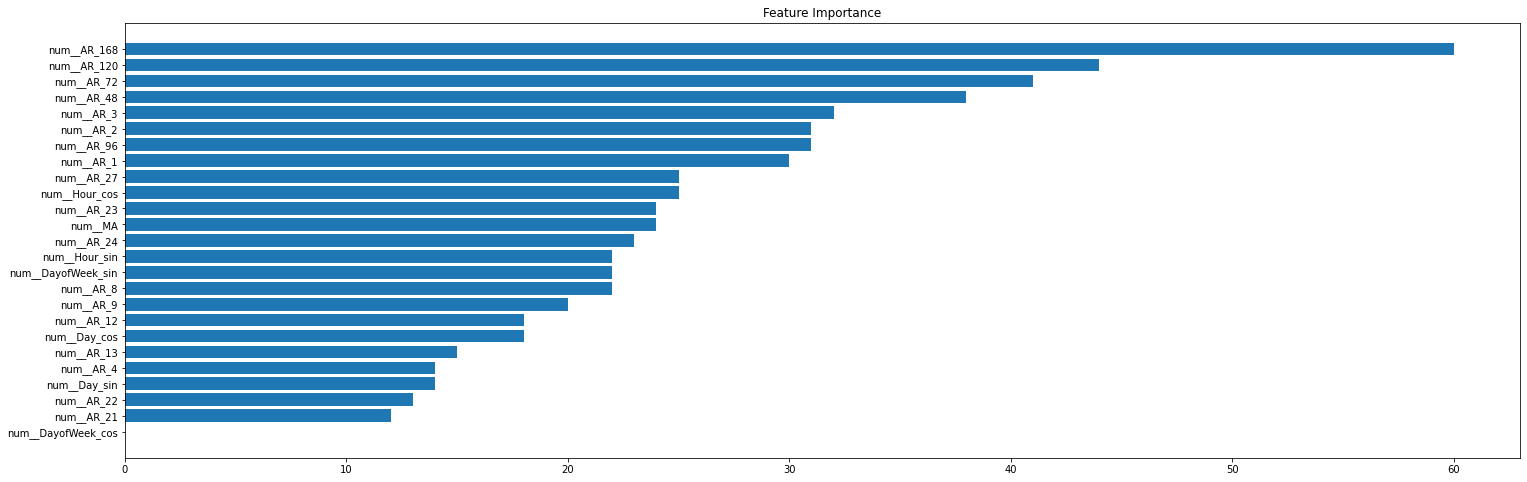

In [311]:
X_train_scaled = final_model['preprocessor'].fit_transform(train[num_col])
model  = final_model['model']
prepr =  final_model['preprocessor']
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(25, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(prepr.get_feature_names_out())[sorted_idx])
plt.title('Feature Importance')
plt.show()

В общем-то все признаки пригодились, кроме "DayofWeek_cos", что в общем-то было ожидаемо по диаграмме корреляций

Определим RMSE для лучшей модели на тестовой выборке

In [327]:
y_pred = final_model.predict(test[num_col])
print('Точность модели на тестовой выборке: RMSE = ',mean_squared_error(test[target].values.ravel(), y_pred, squared=False))

Точность модели на тестовой выборке: RMSE =  37.695114615218884


Чтобы показать, что модель работает сравним ее с результатами константной модель Dummy

In [317]:
Dummy_model = prediction_model(num_col, 'Min/Max', 'Dummy')
Dummy_model.fit(train[num_col], train[target].values.ravel())
y_dummy = Dummy_model.predict(test[num_col])
print('Точность модели на тестовой выборке: RMSE = ',mean_squared_error(test[target].values.ravel(), y_dummy, squared=False))

Точность модели на тестовой выборке: RMSE =  84.45113423436631


Качество модели продемонстировано, покажем результат графически

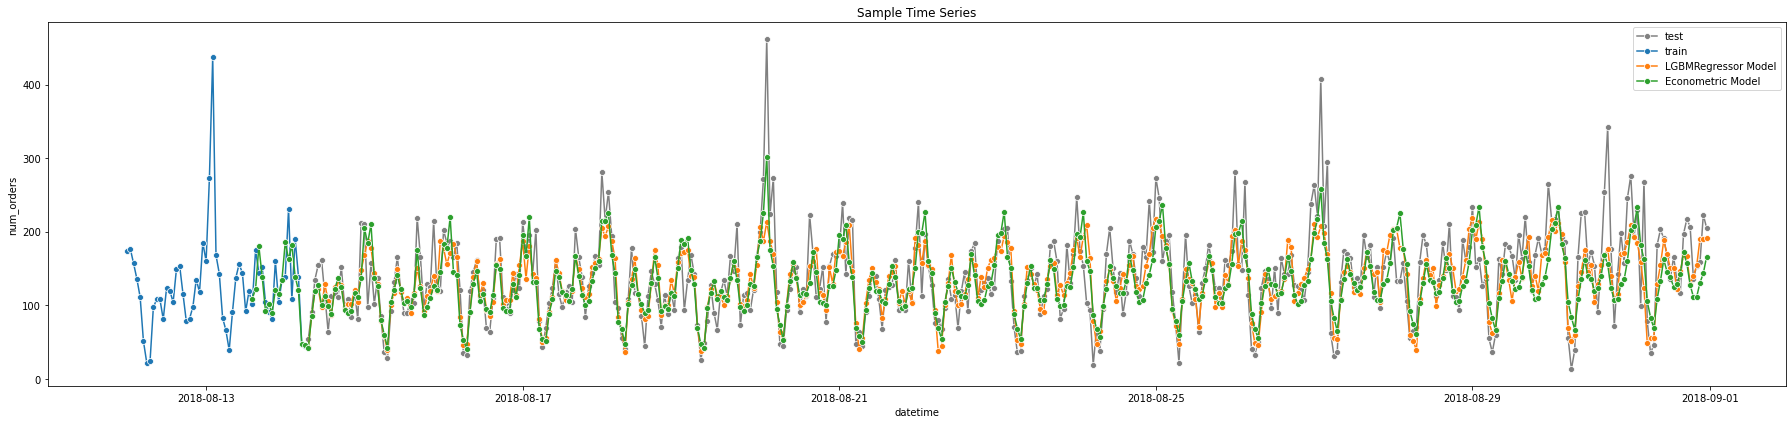

In [343]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
sns.lineplot(frame2model[test.index[0]:test.index.max()]['num_orders'], marker='o', label='test', color='grey')
sns.lineplot(frame2model['2018-08-12':train.index.max()]['num_orders'], marker='o', label='train')
sns.lineplot(x=test.index, y=y_pred, marker='o', label='LGBMRegressor Model')
sns.lineplot(x=taxi2airport.index[train_len:num_samples], y=pred_ec.values, marker='o', label='Econometric Model')
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

## Выводы

* Данные загружены, пропусков и дубликатов не имеется. Произведена сортировка по времени. Произведено ресемплирование данных по часу. Сгенерированы календарные признаки, скользящее среднее и отстающие значения. Полученные данные разделены на обучающую и тестовую выборки. Данные разделены на признаки и целевой признак;
* Произведен анализ трендов и сезонности в данных;
* Подобраны гиперпараметры для моделей;
* Модели обучены и с помощью них сделаны предсказания. RMSE для всех моделей;
* Лучшей моделью из эконометрических является AutoReg, модели класса ARIMA из-за сложности в обучении большого количества признаков склонны игнорировать длительные данные и использовать средние значения;
* Для регрессионных моделей лучшие результаты показала модель LGBMRegressor - значения по кросс-валидации 22.78, а  для тестовых данных 37, что несколько лучше чем для AutoReg модели (порядка 39)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48